# Fraudulent Transactions Detection

### Problem Statement -
This case requires to develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan

##### Importing Necessary Libraries 

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import balanced_accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, make_scorer
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost  import XGBClassifier


#### Loading Dataset

In [52]:
trans_df = pd.read_csv(r"C:\Users\divya\Downloads\Fraud.csv")
print("Dataset Loaded....")

Dataset Loaded....


#### Data Description 

In [53]:
trans_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


In [54]:
#getting dataset information
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [55]:
trans_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

#### Description of columns by Data Dictionary

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).  
**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.  
**amount** - amount of the transaction in local currency.  
**nameOrig** - customer who started the transaction  
**oldbalanceOrg** - initial balance before the transaction    
**newbalanceOrig** - new balance after the transaction  
**nameDest** - customer who is the recipient of the transaction  
**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).  
**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).  
**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.  
**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.  

In [56]:
trans_df.shape

(6362620, 11)

In [57]:
trans_df.type.value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [58]:
indexe_ = trans_df.type.value_counts().index
value_ = trans_df.type.value_counts().values

px.pie(trans_df,values=value_,names=indexe_,title='Distribution of transaction type')

#### Checks for data cleaning

In [59]:
trans_df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There is no null values

#### Statistical Data

In [60]:
numerical_attr = trans_df.select_dtypes(exclude='object')

In [61]:
#statistical analysis of numerical attributes
numerical_attr.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [62]:
#checking for correlation between the attributes
numerical_attr.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.00,0.02,-0.01,-0.01,0.03,0.03,0.03,0.00
amount,0.02,1.00,-0.00,-0.01,0.29,0.46,0.08,0.01
oldbalanceOrg,-0.01,-0.00,1.00,1.00,0.07,0.04,0.01,0.00
newbalanceOrig,-0.01,-0.01,1.00,1.00,0.07,0.04,-0.01,0.00
oldbalanceDest,0.03,0.29,0.07,0.07,1.00,0.98,-0.01,-0.00
newbalanceDest,0.03,0.46,0.04,0.04,0.98,1.00,0.00,-0.00
isFraud,0.03,0.08,0.01,-0.01,-0.01,0.00,1.00,0.04
isFlaggedFraud,0.00,0.01,0.00,0.00,-0.00,-0.00,0.04,1.00


newbalanceDest and oldbalanceDest is correlated.

In [63]:
numerical_attr.skew() 

step               0.38
amount            30.99
oldbalanceOrg      5.25
newbalanceOrig     5.18
oldbalanceDest    19.92
newbalanceDest    19.35
isFraud           27.78
isFlaggedFraud   630.60
dtype: float64

data is largely positively skewed  
For right-skewed data — tail is on the right, positive skew — , common transformations include square root, cube root, and log.

### Variable Transformation

Apply log and boxcox transformation and choose relevant transformations for the respective columns.

In [64]:
from scipy.special import boxcox1p 

skew_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df_logs = trans_df[skew_cols]
df_boxcox = trans_df[skew_cols]
for i in skew_cols: 
    df_logs.loc[:,i] = np.log(df_logs[i]+1)
    df_boxcox.loc[:,i] = boxcox1p(df_boxcox[i], 0.1)

In [65]:
df_logs.skew()

amount           -0.56
oldbalanceOrg    -0.26
newbalanceOrig    0.44
oldbalanceDest   -0.21
newbalanceDest   -0.39
dtype: float64

In [66]:
df_boxcox.skew() 

amount           -0.08
oldbalanceOrg     0.34
newbalanceOrig    0.74
oldbalanceDest   -0.04
newbalanceDest   -0.20
dtype: float64

After observing the skewness after transformation,  

Choose boxcox transformation for amount, oldbalanceDest, newbalanceDest  
Choose log transformation for oldbalanceOrg, newbalanceOrg

In [67]:
df = pd.concat([trans_df[['step','type','nameOrig', 'nameDest','isFraud', 'isFlaggedFraud']],df_logs[['oldbalanceOrg','newbalanceOrig']], df_boxcox[['amount','oldbalanceDest','newbalanceDest']]], axis=1, join='inner') 
print(df.shape)
df.head()

(6362620, 11)


,step,type,nameOrig,nameDest,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest
0,1,PAYMENT,C1231006815,M1979787155,0,0,12.04,11.98,15.08,0.00,0.00
1,1,PAYMENT,C1666544295,M2044282225,0,0,9.96,9.87,11.24,0.00,0.00
2,1,TRANSFER,C1305486145,C553264065,1,0,5.20,0.00,6.83,0.00,0.00
3,1,CASH_OUT,C840083671,C38997010,1,0,5.20,0.00,6.83,17.08,0.00
4,1,PAYMENT,C2048537720,M1230701703,0,0,10.63,10.31,15.51,0.00,0.00


### One-hot Encoding  
Visualize the data for fraud transactions.

In [68]:
df[df.isFraud == 1].tail(30)

,step,type,nameOrig,nameDest,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest
6362590,741,TRANSFER,C509686434,C1310143791,1,0,12.69,0.00,25.56,0.00,0.00
6362591,741,CASH_OUT,C919525792,C993635374,1,0,12.69,0.00,25.56,27.58,29.33
6362592,741,TRANSFER,C457476945,C1688658215,1,0,12.86,0.00,26.17,0.00,0.00
6362593,741,CASH_OUT,C369315575,C2069429837,1,0,12.86,0.00,26.17,32.19,33.02
6362594,741,TRANSFER,C31496887,C1251365829,1,0,11.88,0.00,22.82,0.00,0.00
6362595,741,CASH_OUT,C1092829426,C716019997,1,0,11.88,0.00,22.82,0.00,22.82
6362596,741,TRANSFER,C1112979339,C2114078084,1,0,10.79,0.00,19.41,0.00,0.00
6362597,741,CASH_OUT,C1706094385,C2109905271,1,0,10.79,0.00,19.41,27.25,27.58
6362598,742,TRANSFER,C1044665079,C750074708,1,0,15.20,0.00,35.74,0.00,0.00
6362599,742,CASH_OUT,C1970706589,C637394241,1,0,15.20,0.00,35.74,30.64,36.98


we observe that customer-to customer transactions has more frauds than other relationship.

In [69]:
import re  
df['nameOrig'] = df['nameOrig'].apply(lambda x: re.sub('C[A-Za-z0-9]*', 'C',x)) 
df['nameDest'] = df['nameDest'].apply(lambda x: re.sub('C[A-Za-z0-9]*','C',x))   
df['nameDest'] = df['nameDest'].apply(lambda x: re.sub('M[A-Za-z0-9]*','M',x)) 
df.head()

,step,type,nameOrig,nameDest,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest
0,1,PAYMENT,C,M,0,0,12.04,11.98,15.08,0.00,0.00
1,1,PAYMENT,C,M,0,0,9.96,9.87,11.24,0.00,0.00
2,1,TRANSFER,C,C,1,0,5.20,0.00,6.83,0.00,0.00
3,1,CASH_OUT,C,C,1,0,5.20,0.00,6.83,17.08,0.00
4,1,PAYMENT,C,M,0,0,10.63,10.31,15.51,0.00,0.00


In [70]:
df[df.isFraud == 1].type.value_counts()

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

In [71]:
from sklearn import preprocessing 
ohe = preprocessing.OneHotEncoder()                                       
df= pd.get_dummies(df, columns=['type','nameOrig', 'nameDest'])
df.head(3)

,step,isFraud,isFlaggedFraud,oldbalanceOrg,newbalanceOrig,amount,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,nameOrig_C,nameDest_C,nameDest_M
0,1,0,0,12.04,11.98,15.08,0.00,0.00,False,False,False,True,False,True,False,True
1,1,0,0,9.96,9.87,11.24,0.00,0.00,False,False,False,True,False,True,False,True
2,1,1,0,5.20,0.00,6.83,0.00,0.00,False,False,False,False,True,True,True,False


### Modelling

In [72]:
features = ['step', 'isFlaggedFraud', 'oldbalanceOrg', 'newbalanceOrig',
       'amount', 'oldbalanceDest', 'newbalanceDest', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
       'nameOrig_C', 'nameDest_C', 'nameDest_M']  
target=['isFraud'] 

x_train, x_test, y_train, y_test = train_test_split(df[features],df['isFraud'], test_size=0.2, random_state=42)

In [73]:
len(x_train), len(x_test)

(5090096, 1272524)

In [74]:
y_test.value_counts() 

isFraud
0    1270904
1       1620
Name: count, dtype: int64

Imbalance in training set will result in poor model.  
Thus sampling of training set is employed.

### Sampling

SMOTE is used to oversample the minority class-here ‘Fraud’(1) class  
Minority class is sampled with 0.025 times the majority class  
Not-Fraud class (0) is undersampled to double the number of ‘Fraud’ class

In [75]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from collections import Counter 
over = SMOTE(sampling_strategy=0.025) 
under=RandomUnderSampler(random_state=42, sampling_strategy=0.5)
steps = [('o', over),('u', under)] 
pipeline = Pipeline(steps=steps) 
x_res, y_res = pipeline.fit_resample(x_train[features], y_train) 
print(Counter(y_res))

Counter({0: 254174, 1: 127087})


## Fit the Model 

In [76]:
def Model_scores(model_name, y_true, y_pred):
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 4), 
                         'Precision': np.round(precision, 4), 
                         'Recall': np.round(recall, 4),
                         'F1': np.round(f1, 4)},
                        index=[model_name])

### *Random Forest Classifier*

In [77]:
Rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, n_jobs=-1)
Rf.fit(x_train,y_train)
y_predict = Rf.predict(x_test)

Model_scores('Random Forest',y_test,y_predict)

,Balanced Accuracy,Precision,Recall,F1
Random Forest,0.89,0.99,0.78,0.87


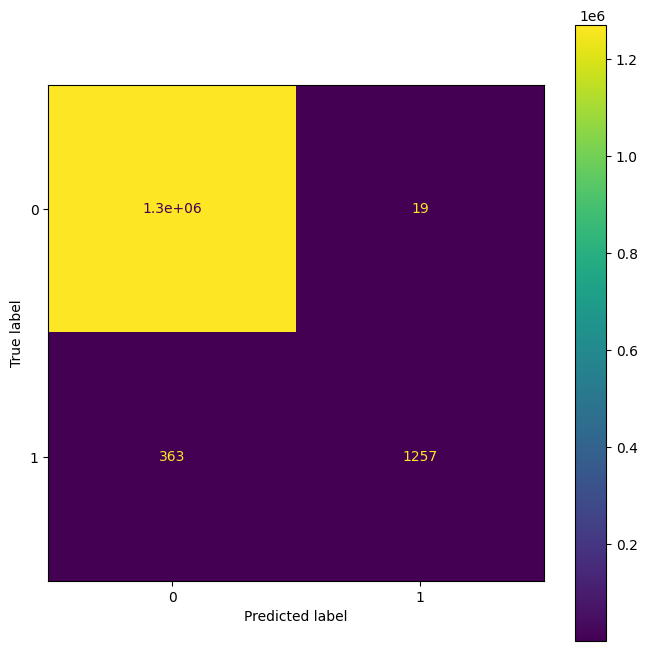

In [78]:
fig, ax = plt.subplots(figsize = (8,8))
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true = y_test,y_pred = y_predict, ax=ax);

### *Logistic Regression*

In [79]:
Lr = LogisticRegression(C=0.20433597178569418, solver = "liblinear")
Lr.fit(x_train,y_train)
y_predict = Lr.predict(x_test)

Model_scores('Logistic Regression',y_test,y_predict)

,Balanced Accuracy,Precision,Recall,F1
Logistic Regression,0.75,0.93,0.50,0.65


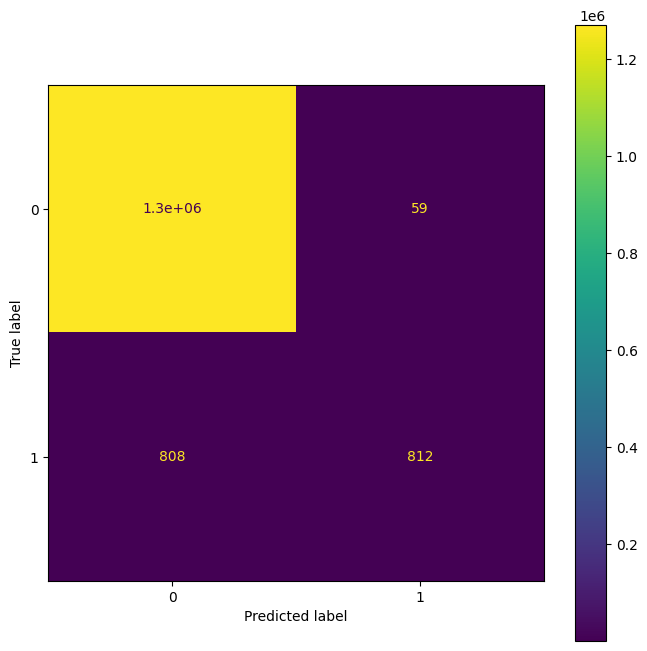

In [80]:
fig, ax = plt.subplots(figsize = (8,8))
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true = y_test,y_pred = y_predict, ax=ax);